In [1]:
import numpy as np
import pandas as pd

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
from nltk.tag import pos_tag
from nltk import ne_chunk
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Models to use
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

# Scoring metrics
from sklearn.metrics import accuracy_score, f1_score, make_scorer

import re
# import unicodedata
from textblob import TextBlob
from spellchecker import SpellChecker
from pattern.en import suggest
from num2words import num2words
import contractions
import random
from deep_translator import GoogleTranslator
from langdetect import detect_langs
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
df = pd.read_csv("train.csv")

In [3]:
pd.set_option('display.max_colwidth', None)

### EDA

#### Sentiment Legend
* **2**   ***News***: the tweet links to factual news about climate change

* **1**   ***Pro***: the tweet supports the belief of man-made climate change 

* **0**   ***Neutral***: the tweet neither supports nor refutes the belief of man-made climate change 

* **-1**  ***Anti***: the tweet does not believe in man-made climate change

In [4]:
df.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [5]:
df.shape

(15819, 3)

In [6]:
# Categories are imbalanced
sent_cat = df['sentiment'].value_counts()
sent_cat

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Label Balance')

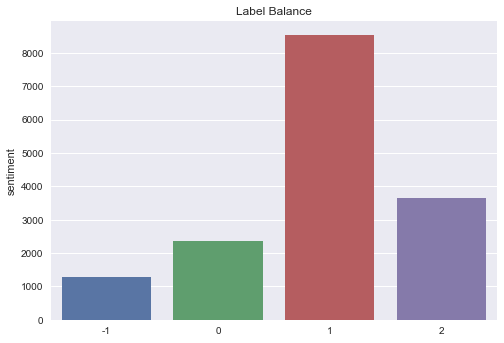

In [7]:
sns.barplot(x=sent_cat.index, y=sent_cat);
plt.title('Label Balance')

In [8]:
# Percentage of sentiment categories
print("Pro: ", round(df['sentiment'].value_counts()[1] / df.shape[0] * 100, 2),"%")
print("Neutral: ", round(df['sentiment'].value_counts()[0] / df.shape[0] * 100, 2),"%")
print("Anti: ", round(df['sentiment'].value_counts()[-1] / df.shape[0] * 100, 2),"%")
print("News: ", round(df['sentiment'].value_counts()[2] / df.shape[0] * 100, 2),"%")

Pro:  53.92 %
Neutral:  14.87 %
Anti:  8.19 %
News:  23.01 %


In [9]:
# Missing values
df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

### Length Analysis

In [10]:
# Word count
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
print('Anti tweet average Word Count     ', df[df['sentiment'] == -1]['word_count'].mean()) #Anti Tweets
print('Neutral tweet average Word Count  ', df[df['sentiment'] == 0]['word_count'].mean()) #Neutral tweets
print('Pro tweet average Word Count      ', df[df['sentiment'] == 1]['word_count'].mean()) #Pro tweets
print('News tweet average Word Count     ', df[df['sentiment'] == 2]['word_count'].mean()) #News tweets

Anti tweet average Word Count      18.373456790123456
Neutral tweet average Word Count   16.555461113472163
Pro tweet average Word Count       18.870457209847597
News tweet average Word Count      15.392307692307693


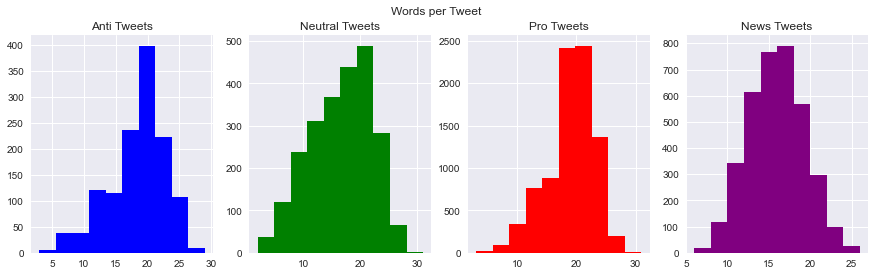

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

word_count = df[df['sentiment'] == -1]['word_count']
ax1.hist(word_count, color='blue')
ax1.set_title('Anti Tweets')

word_count = df[df['sentiment'] == 0]['word_count']
ax2.hist(word_count, color='green')
ax2.set_title('Neutral Tweets')

word_count = df[df['sentiment'] == 1]['word_count']
ax3.hist(word_count, color='red')
ax3.set_title('Pro Tweets')

word_count = df[df['sentiment'] == 2]['word_count']
ax4.hist(word_count, color='purple')
ax4.set_title('News Tweets')

fig.suptitle('Words per Tweet')
plt.show()

In [12]:
# Character count
df['char_count'] = df['message'].apply(lambda x: len(str(x)))
print('Anti tweet average Character Count          ', df[df['sentiment'] == -1]['char_count'].mean()) #Anti Tweets
print('Neutral tweet average Character Word Count  ', df[df['sentiment'] == 0]['char_count'].mean()) #Neutral tweets
print('Pro tweet average Character Word Count      ', df[df['sentiment'] == 1]['char_count'].mean()) #Pro tweets
print('News tweet average Character Word Count     ', df[df['sentiment'] == 2]['char_count'].mean()) #News tweets

Anti tweet average Character Count           123.7253086419753
Neutral tweet average Character Word Count   110.92520186995326
Pro tweet average Character Word Count       128.9706916764361
News tweet average Character Word Count      119.91978021978022


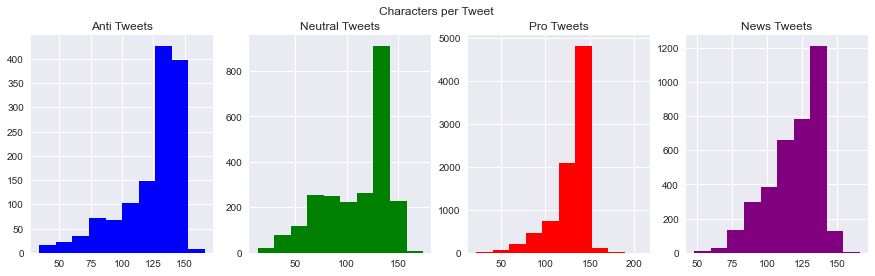

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

char_count = df[df['sentiment'] == -1]['char_count']
ax1.hist(char_count, color='blue')
ax1.set_title('Anti Tweets')

char_count = df[df['sentiment'] == 0]['char_count']
ax2.hist(char_count, color='green')
ax2.set_title('Neutral Tweets')

char_count = df[df['sentiment'] == 1]['char_count']
ax3.hist(char_count, color='red')
ax3.set_title('Pro Tweets')

char_count = df[df['sentiment'] == 2]['char_count']
ax4.hist(char_count, color='purple')
ax4.set_title('News Tweets')

fig.suptitle('Characters per Tweet')
plt.show()

In [14]:
# Unique word count
df['unique_word_count'] = df['message'].apply(lambda x: len(set(str(x).split())))
print('Anti tweet average Unique Word Count     ', df[df['sentiment'] == -1]['unique_word_count'].mean()) #Anti Tweets
print('Neutral tweet average Unique Word Count  ', df[df['sentiment'] == 0]['unique_word_count'].mean()) #Neutral tweets
print('Pro tweet average Unique Word Count      ', df[df['sentiment'] == 1]['unique_word_count'].mean()) #Pro tweets
print('News tweet average Unique Word Count     ', df[df['sentiment'] == 2]['unique_word_count'].mean()) #News tweets

Anti tweet average Unique Word Count      17.790895061728396
Neutral tweet average Unique Word Count   16.014024649383764
Pro tweet average Unique Word Count       18.232121922626025
News tweet average Unique Word Count      15.182692307692308


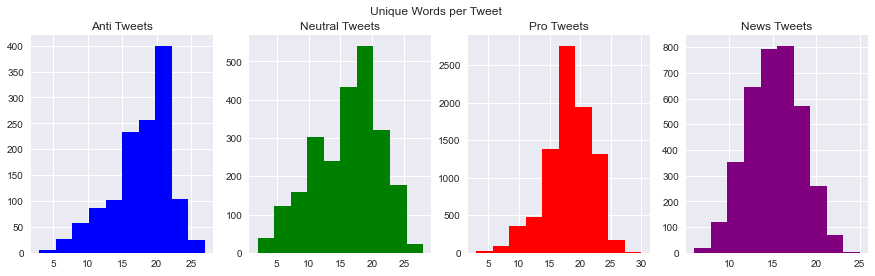

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

unique_word_count = df[df['sentiment'] == -1]['unique_word_count']
ax1.hist(unique_word_count, color='blue')
ax1.set_title('Anti Tweets')

unique_word_count = df[df['sentiment'] == 0]['unique_word_count']
ax2.hist(unique_word_count, color='green')
ax2.set_title('Neutral Tweets')

unique_word_count = df[df['sentiment'] == 1]['unique_word_count']
ax3.hist(unique_word_count, color='red')
ax3.set_title('Pro Tweets')

unique_word_count = df[df['sentiment'] == 2]['unique_word_count']
ax4.hist(unique_word_count, color='purple')
ax4.set_title('News Tweets')

fig.suptitle('Unique Words per Tweet')
plt.show()

In [16]:
# Sentence count
df['sentence_count'] = df['message'].apply(lambda x: len(str(x).split('.')))
print('Anti tweet average Sentence Count     ', df[df['sentiment'] == -1]['sentence_count'].mean()) #Anti Tweets
print('Neutral tweet average Sentence Count  ', df[df['sentiment'] == 0]['sentence_count'].mean()) #Neutral tweets
print('Pro tweet average Sentence Count      ', df[df['sentiment'] == 1]['sentence_count'].mean()) #Pro tweets
print('News tweet average Sentence Count     ', df[df['sentiment'] == 2]['sentence_count'].mean()) #News tweets

Anti tweet average Sentence Count      2.4367283950617282
Neutral tweet average Sentence Count   2.183595410114747
Pro tweet average Sentence Count       2.324736225087925
News tweet average Sentence Count      2.3865384615384615


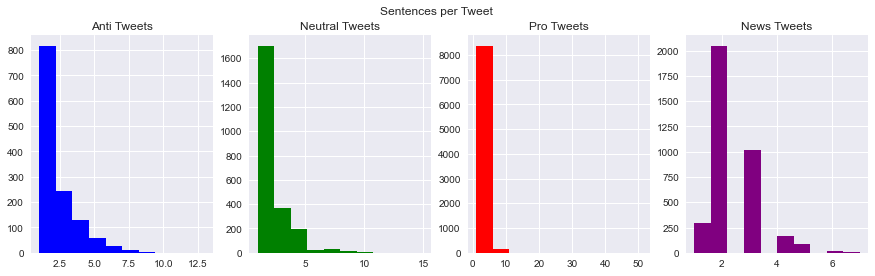

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

sentence_count = df[df['sentiment'] == -1]['sentence_count']
ax1.hist(sentence_count, color='blue')
ax1.set_title('Anti Tweets')

sentence_count = df[df['sentiment'] == 0]['sentence_count']
ax2.hist(sentence_count, color='green')
ax2.set_title('Neutral Tweets')

sentence_count = df[df['sentiment'] == 1]['sentence_count']
ax3.hist(sentence_count, color='red')
ax3.set_title('Pro Tweets')

sentence_count = df[df['sentiment'] == 2]['sentence_count']
ax4.hist(sentence_count, color='purple')
ax4.set_title('News Tweets')

fig.suptitle('Sentences per Tweet')
plt.show()

### Word Clouds by Sentiment

In [18]:
def gen_word_could(df, col, sent_code, sent_name):
    text = df[df['sentiment'] == sent_code]

    # Generate wordcloud
    wordcloud = WordCloud(
        width = 1000, 
        height = 800, 
        random_state=42, 
        background_color='black', 
        colormap='Set2', 
        collocations=False, 
        stopwords = STOPWORDS).generate(str(text[col]))
    # Set figure size
    plt.figure(figsize=(5, 4))
    plt.imshow(wordcloud)
    plt.title(f'Sentiment: {sent_code} {sent_name}')
    # No axis details
    plt.axis("off");
    plt.tight_layout()

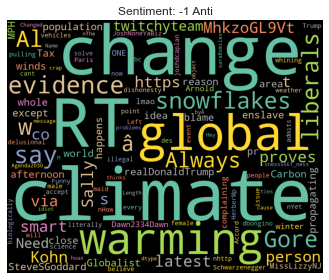

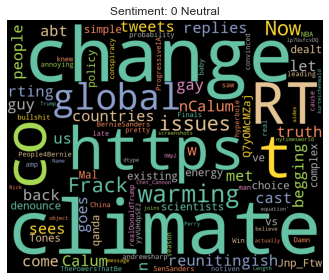

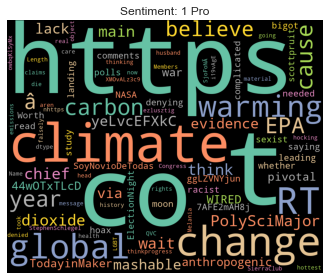

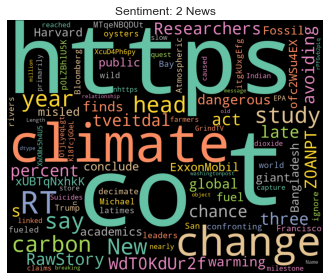

In [19]:
gen_word_could(df, 'message', -1, 'Anti')
gen_word_could(df, 'message', 0, 'Neutral')
gen_word_could(df, 'message', 1, 'Pro')
gen_word_could(df, 'message', 2, 'News')

### Pre-Processing

In [20]:
def remove_handle(text):
    '''
    Remove the Twitter handles from the text.
    '''
    twitter_handle = r'@[a-zA-Z0-9_]{0,15}'
    cleaned = re.sub(twitter_handle, ' ', text)
    return cleaned

In [21]:
def remove_hashtags(text):
    '''
    Remove the Hashtags from the text.
    '''
    hashtags = r'#+[a-zA-Z0-9(_)]{1,}'
    cleaned = re.sub(hashtags, ' ', text)
    return cleaned

In [22]:
def remove_url(text):
    '''
    Remove the URL's from the text.
    '''
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    partial_url = r'\bht.[^\s]*'
    cleaned = re.sub(pattern_url, '', text)
    cleaned = re.sub(partial_url, '', text)
    return cleaned

In [23]:
def remove_numbers(text):
    '''
    Remove the numbers from the text.
    '''
    numbers = r'\w*\d\w*'
    cleaned = re.sub(numbers, ' ', text)
    return cleaned

In [24]:
def lower_case_text(text):
    '''
    Lowercase the text.
    '''
    cleaned = text.lower()
    return cleaned

In [25]:
def remove_non_alpha(text):
    '''
    Remove the non alpha numeric characters from the text.
    '''
    non_alpha = r'[^a-zA-Z\d\s]'
    cleaned = re.sub(non_alpha, ' ', text)
    return cleaned

In [26]:
def remove_stopwords(text):
    '''
    Remove the Stopwords from the text.
    In this case only 'rt'
    '''
    stop_words = ['rt']

    filtered_sentence = ' '.join([word for word in text.split() if word not in stop_words])
    return filtered_sentence

In [27]:
def remove_whitespace(text):
    '''
    Remove the extra whitespaces from the text.
    '''
    whitespace = r'\s+'
    cleaned = re.sub(whitespace, ' ', text)
    return cleaned

In [28]:
def remove_single_characters(text):
    '''
    Remove random single text characters from the text.
    '''
    single_character = r'\b[a-zA-Z]\b'
    cleaned = re.sub(single_character, ' ', text)
    return cleaned

In [29]:
def expand_contractions(text):
    '''
    Expand contraction in the text.
    '''
    text_list = text.split()
    expanded_list = []
    for word in text_list:
        expanded_list.append(contractions.fix(word))
        
    new_text = ' '.join(expanded_list)

    return new_text

In [30]:
def lemmatize_text(text):
    '''
    Lemmatize the text.
    '''
    lemmatizer  = WordNetLemmatizer()
    lemmatized_sentence = ''.join([lemmatizer.lemmatize(w) for w in text])
    return lemmatized_sentence

In [31]:
def preprocess(file_import, stemming=False, lemmatize=False):
    '''
    Preprocess the tweets in the dataframe.
    '''
    if file_import == 'train':
        df = pd.read_csv("train.csv")
    elif file_import == 'test':
        df = pd.read_csv("test.csv")
    else:
        error = 'Incorrect File Name!!'
        return error  

    # Remove twitter handles
    df['clean_tweet'] = df['message'].apply(lambda text: remove_handle(text))
    # Remove hashtags
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_hashtags(text))
    # Remove url's
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_url(text))

    # Remove all non alphanumeric characters
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_non_alpha(text))
    # Remove numbers
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_numbers(text))
    # Set to lower case
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: lower_case_text(text))
    # Remove single characters
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_single_characters(text))
    # Remove extra whitespace
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_whitespace(text))
    
    df['clean_tweet'] = df['clean_tweet'].apply(lambda text: remove_stopwords(text))
    
    df['message'] = df['clean_tweet']

    df = df.drop(['clean_tweet'], 1)
    return df   

In [32]:
processed_df = preprocess('train')

In [33]:
processed_df

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn think carbon dioxide is main cause of global warming and wait what via,625221
1,1,it not like we lack evidence of anthropogenic global warming,126103
2,2,researchers say we have three years to act on climate change before it too late,698562
3,1,wired was pivotal year in the war on climate change,573736
4,1,it and racist sexist climate change denying bigot is leading in the polls,466954
...,...,...,...
15814,1,they took down the material on global warming lgbt rights and health care but now they re hocking melania qvc,22001
15815,2,how climate change could be breaking up million year old relationship,17856
15816,0,notiven nytimesworld what does trump actually believe about climate change rick perry joins other aides in,384248
15817,-1,hey liberals the climate change crap is hoax that ties to the climate is being changed by,819732


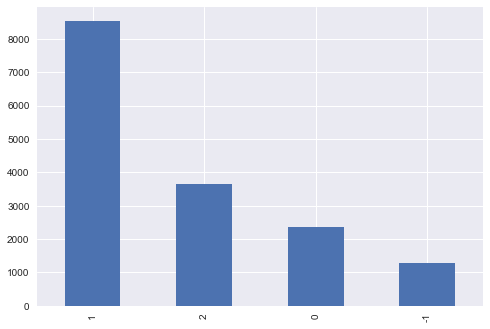

In [34]:
processed_df['sentiment'].value_counts().plot(kind='bar');

In [35]:
def tfidf_vectorization_training(df):
    '''
    Transform the data to a tfidf vector. This is for the training set.
    '''
    # Split the data between features and the label
    X = df.drop(['sentiment', 'tweetid'], 1)
    y = df['sentiment']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['message']).toarray()
    X_test_tfidf = tfidf_vectorizer.transform(X_test['message']).toarray()
    
    X_train = pd.DataFrame(X_train_tfidf, columns=tfidf_vectorizer.get_feature_names())
    X_test = pd.DataFrame(X_test_tfidf, columns=tfidf_vectorizer.get_feature_names())
    
    return X_train, y_train, X_test, y_test

In [36]:
def tfidf_vectorization_all_training(df):
    '''
    Transform the data to a tfidf vector. This is for the full training set.
    '''
    # Split the data between features and the label
    X = df.drop(['sentiment', 'tweetid'], 1)
    y = df['sentiment']
    
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X['message']).toarray()
    
    X = pd.DataFrame(X_train_tfidf, columns=tfidf_vectorizer.get_feature_names())
    
    return X, y, tfidf_vectorizer

In [37]:
def vectorize_and_smote(df):
    '''
    Transform the data to a tfidf vector. This is for the full training set.
    The apply smote to balance the labels in the data set.
    '''
    # Vectorize the text and then apply smote to balance out the labels/classes.
    X = df.drop(['sentiment', 'tweetid'], 1)
    y = df['sentiment']
    
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X['message']).toarray()
    
    X_train_tfidf_df = pd.DataFrame(X_train_tfidf, columns=tfidf_vectorizer.get_feature_names())
    
    oversample = SMOTE()
    X_features, label_y = oversample.fit_resample(X_train_tfidf_df, y)
    
    return X_features, label_y, tfidf_vectorizer

In [38]:
def tfidf_vectorization_test_sub(df, fitted_vectorizer):
    '''
    Apply the tfidf vectorizer to the test set of data.
    '''
    # Split the data between features and the label
    X = df.drop(['tweetid'], 1)
    tweetid = df['tweetid']
    
    X_tfidf = fitted_vectorizer.transform(X['message']).toarray()
    
    X = pd.DataFrame(X_tfidf, columns=fitted_vectorizer.get_feature_names())
    
    return X

In [39]:
def count_vectorization_training(df):
    '''
    Transform the data to a count vectorizer. This is for the full training set.
    '''
    # Split the data between features and the label
    X = df.drop(['sentiment', 'tweetid'], 1)
    y = df['sentiment']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    count_vectorizer = CountVectorizer()
    X_train_cv = count_vectorizer.fit_transform(X_train['message']).toarray()
    X_test_cv = count_vectorizer.transform(X_test['message']).toarray()
    
    X_train = pd.DataFrame(X_train_cv, columns=count_vectorizer.get_feature_names())
    X_test = pd.DataFrame(X_test_cv, columns=count_vectorizer.get_feature_names())
    
    return X_train, y_train, X_test, y_test

In [40]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [41]:
def word2vec_vectorization_training(df):
    '''
    Create a word2vec vector and fit and transform it to the data.
    '''
    # Split the data between features and the label
    X = df.drop(['sentiment', 'tweetid'], 1)
    y = df['sentiment']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    all_messages_list = []
    for i in X_train['message']:
        li = list(i.split(' '))
        all_messages_list.append(li)

    w2v_model = Word2Vec(all_messages_list, min_count=1, vector_size=200, workers=4, sg=1)
    
    w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
    
    w2v_vectorizer = MeanEmbeddingVectorizer(w2v)
    X_train_w2v = w2v_vectorizer.fit(X_train['message'], y_train)
    X_train_w2v = w2v_vectorizer.transform(X_train['message'])
    X_test_w2v = w2v_vectorizer.transform(X_test['message'])
    
    X_train = pd.DataFrame(X_train_w2v)
    X_test = pd.DataFrame(X_test_w2v)
    
    return X_train, y_train, X_test, y_test

### Testing of models

In [50]:
X_train, y_train, X_test, y_test = tfidf_vectorization_training(processed_df)

In [118]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, label_y, test_size=0.2, random_state=42)

In [27]:
# Check different models
names = [
#     'Naive Bayes MN',
    'Naive Bayes Bernoulli',
#     'Support Vector Machine',
    'Logistic Regression',  
    'Random Forest',
#     'Stochastic Gradient Descent',
#     'AdaBoostClassifier'
]

In [28]:
classifiers = [
#     MultinomialNB(),
    BernoulliNB(),
#     SVC(),
    LogisticRegression(max_iter=10000), 
    RandomForestClassifier(),
#     SGDClassifier(),
#     AdaBoostClassifier()
]

In [121]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [122]:
scorer = make_scorer(f1_score, average='weighted')

In [123]:
for name, clf in zip(names, classifiers):
    print(f'Doing {name} Cross-Validation...')
    results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring=scorer)
    print(f'The mean F1 score for {name} is: ', results.mean())
    print()

Doing Naive Bayes Bernoulli Cross-Validation...
The mean F1 score for Naive Bayes Bernoulli is:  0.8171929960395404

Doing Logistic Regression Cross-Validation...
The mean F1 score for Logistic Regression is:  0.8280597901182255

Doing Random Forest Cross-Validation...
The mean F1 score for Random Forest is:  0.8734976513466326



In [25]:
scores = {}
for name, clf in zip(names, classifiers):
    print(f'Fitting {name} on training set...')
    clf.fit(X_train, y_train)
    print(f'Predicting {name} on training set...')
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1_score is :", f1)
    print()
    scores[name] = f1

Fitting Naive Bayes Bernoulli on training set...
Predicting Naive Bayes Bernoulli on training set...
F1_score is : 0.6773112247257868

Fitting Logistic Regression on training set...
Predicting Logistic Regression on training set...
F1_score is : 0.7291289030109083

Fitting Random Forest on training set...
Predicting Random Forest on training set...
F1_score is : 0.6845070910668818

Fitting Stochastic Gradient Descent on training set...
Predicting Stochastic Gradient Descent on training set...
F1_score is : 0.7284157236530816

Fitting AdaBoostClassifier on training set...
Predicting AdaBoostClassifier on training set...
F1_score is : 0.6081860184066883



## All Training Fit

In [42]:
processed_df = preprocess('train')

In [43]:
processed_df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn think carbon dioxide is main cause of global warming and wait what via,625221
1,1,it not like we lack evidence of anthropogenic global warming,126103
2,2,researchers say we have three years to act on climate change before it too late,698562
3,1,wired was pivotal year in the war on climate change,573736
4,1,it and racist sexist climate change denying bigot is leading in the polls,466954


In [44]:
X_all, y_all, fitted_vectorizer = vectorize_and_smote(processed_df)

In [54]:
LR = LogisticRegression(max_iter=10000)
LR.fit(X_all, y_all)

LogisticRegression(max_iter=10000)

In [45]:
RFC = RandomForestClassifier()
RFC.fit(X_all, y_all)

RandomForestClassifier()

In [46]:
# Create a function to perform the necesary steps for submission
def submission(model, fitted_vectorizer):
    df_test = preprocess('test')

    X_test_all = tfidf_vectorization_test_sub(df_test, fitted_vectorizer)
    
    # Predict with the model
    y_prediction_all_test = model.predict(X_test_all)
    
    # Convert to a dataframe
    df_predictions = pd.DataFrame(y_prediction_all_test, columns=['sentiment'])
    
    # Join the index and the predictions
    output = pd.DataFrame({"tweetid":df_test['tweetid']})
    submission = output.join(df_predictions)
    # Create the CSV to Submit
    submission.to_csv("climate_change_submission.csv", index=False)
    # Return the submission df
    return submission

In [48]:
submission(RFC, fitted_vectorizer)

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,0
10542,875167,1
10543,78329,2
10544,867455,0
